In [10]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from datasets.pmemo import PMEmoDataset
from utils import *
from paths import *
from helpers.audio import MadmomAudioProcessor
from nb_helpers import *
from model import RFResnetExplainable

In [11]:
model_path = './trained_models/CPResnet_Explainable_6d772_0.pt'
net = RFResnetExplainable(num_interpretable_concepts=7, num_targets=2).to(device)
load_model(model_path, net)
w = net.feed_forward.weight.detach().numpy()
aud_len = 40

CONFIG:
{'name': 'config_cp_field_shallow_m2', 'input_shape': [8, 1, -1, -1], 'n_classes': 7, 'depth': 26, 'base_channels': 128, 'n_blocks_per_stage': [3, 1, 1], 'stage1': {'maxpool': [1, 2], 'k1s': [3, 3, 3], 'k2s': [1, 3, 3]}, 'stage2': {'maxpool': [], 'k1s': [3], 'k2s': [3]}, 'stage3': {'maxpool': [], 'k1s': [1], 'k2s': [1]}, 'block_type': 'basic'}


In [12]:
pmemo_test_ids = np.load('./data_splits/test_ids_seed=42.npy')
pmemo_ann = pd.read_csv(path_pmemo_static_annotations)
pmemo_dataset = PMEmoDataset(select_song_ids=pmemo_test_ids, duration=aud_len, scale_labels=True)

dataset = pmemo_dataset
audio_dir = path_pmemo_audio_dir
dataset_root = path_pmemo_root
genres_df = pd.read_csv('./additional_data/pmemo_genre_tags_musicnn.csv')

# Hiphop vs Valence Error

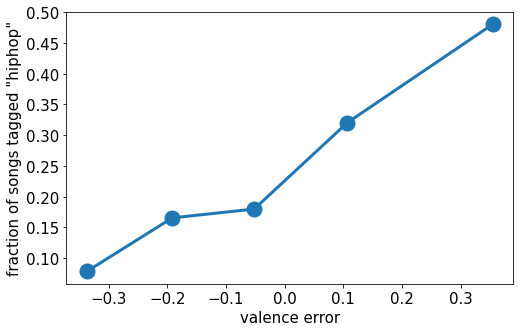

In [13]:
pmemo_dataset_full = PMEmoDataset(duration=aud_len, scale_labels=True)
preds_df_all_pmemo = get_preds_df_for_model(model_path, net, 'pmemo_full', pmemo_dataset_full)
plot_fraction_of_genre_vs_error(preds_df_all_pmemo, emotion='valence', genre='hiphop', num_quantiles=6)

In [14]:
preds_df_biased = preds_df_all_pmemo[preds_df_all_pmemo['song_ids'].isin([str(i)+'.mp3' for i in pmemo_test_ids])]
hip_df = preds_df_biased[preds_df_biased['tags']=='hiphop']
other_df = preds_df_biased[preds_df_biased['tags']!='hiphop']

## Relative effect of midlevel features towards valence

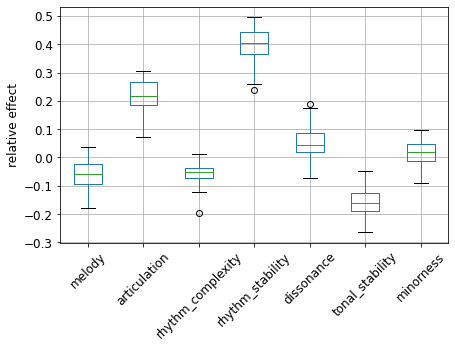

In [16]:
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 8})
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'lines.linewidth' : 3})
hip_eff = hip_df[ml_names].mul(w[1])
hip_eff_abs = hip_eff.apply(np.abs)
hip_eff_sum = hip_eff_abs.sum(axis=1)
hip_eff_rel = hip_eff.div(hip_eff_sum, axis=0)
# fig, ax = plt.subplots(figsize)
hip_eff_rel.boxplot(rot=45, figsize=(6.5,5))
plt.ylabel("relative effect")
plt.tight_layout()

## Generate explanations


In [17]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     exp_list, exp_w_list, exp_aud_list, orig_aud_list, neighbor_labels = generate_explanations(other_df['song_ids'].values, [3]*len(pe_idx_list_other), net, audio_dir, aud_len, use_effects=False)

# df_valence_pos_eff_hip.insert(loc=df_valence_pos_eff_hip.shape[1], column='expl', value=exp_list)
# df_valence_pos_eff_hip.insert(loc=df_valence_pos_eff_hip.shape[1], column='expl_w', value=exp_w_list)
# df_valence_pos_eff_hip.insert(loc=df_valence_pos_eff_hip.shape[1], column='expl_aud_path', value=exp_aud_list)
# df_valence_pos_eff_hip.insert(loc=df_valence_pos_eff_hip.shape[1], column='orig_aud_path', value=orig_aud_list)
# df_valence_pos_eff_hip.insert(loc=df_valence_pos_eff_hip.shape[1], column='neighbor_labels', value=neighbor_labels)

In [18]:
# pickledump(exp_list, f'./cached_material/exp_othergenres_rhythmstability.list')
# pickledump(exp_w_list, f'./cached_material/exp_w_othergenres_rhythmstability.list')
# pickledump(exp_aud_list, f'./cached_material/exp_aud_othergenres_rhythmstability.list')
# pickledump(orig_aud_list, f'./cached_material/orig_aud_othergenres_rhythmstability.list')
# pickledump(neighbor_labels, f'./cached_material/neighbors_othergenres_rhythmstability.list')


exp_list = pickleload(f'./cached_material/exp_othergenres_rhythmstability.list')
exp_w_list = pickleload(f'./cached_material/exp_w_othergenres_rhythmstability.list')
exp_aud_list = pickleload(f'./cached_material/exp_aud_othergenres_rhythmstability.list')
orig_aud_list = pickleload(f'./cached_material/orig_aud_othergenres_rhythmstability.list')
neighbor_labels = pickleload(f'./cached_material/neighbors_othergenres_rhythmstability.list')


In [43]:
counts = Counter([i[0] for i in exp_list])
ex_sources = [i[0] for i in counts.most_common()]
all_sources = ['vocals', 'piano', 'drums', 'bass', 'other']
sources_counts = [i[1] for i in counts.most_common()] + [0]*(len(all_sources)- len(ex_sources))
all_sources_ordered = ex_sources+list(set(all_sources).difference(ex_sources))

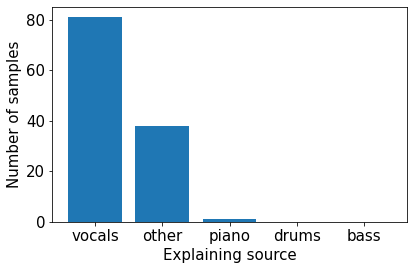

In [44]:
fig, ax = plt.subplots()
ax.bar(np.arange(0,5), sources_counts);
ax.set_xticks(list(range(5)))
ax.set_xticklabels(all_sources_ordered)
ax.set_ylabel("Number of samples")
ax.set_xlabel("Explaining source")
plt.tight_layout()
# plt.show()
plt.savefig('./plots/sources.png')

# Combined model (retraining on both datasets)

In [21]:
model_path, model_paths_root, split_seed = get_model_path(split=311, avdset='combined', run=2)
# model_path, model_paths_root, split_seed = get_model_path(hash_id='41331', run=1)
load_model(model_path, net)
w = net.feed_forward.weight.detach().numpy()

In [22]:
preds_df_combined = get_preds_df_for_model(model_path, net, 'pmemo', pmemo_dataset)
hip_df_combined = preds_df_combined[preds_df_combined['tags']=='hiphop']
other_df_combined = preds_df_combined[preds_df_combined['tags']!='hiphop']

## Relative effect of midlevel features towards valence

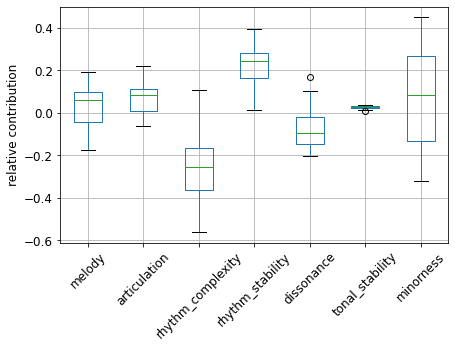

In [23]:
hip_eff_combined = hip_df_combined[ml_names].mul(w[1])
hip_eff_combined_abs = hip_eff_combined.apply(np.abs)
hip_eff_combined_sum = hip_eff_combined_abs.sum(axis=1)
hip_eff_combined_rel = hip_eff_combined.div(hip_eff_combined_sum, axis=0)
hip_eff_combined_rel.boxplot(rot=45, figsize=(6.5,5))
plt.ylabel("relative contribution")
plt.tight_layout()

In [24]:
pmemo_overestimate_other = other_df[other_df['va_err']>0]['va_err'].mean()
pmemo_overestimate_hiphop = hip_df[hip_df['va_err']>0]['va_err'].mean()

combined_overestimate_other = other_df_combined[other_df_combined['va_err']>0]['va_err'].mean()
combined_overestimate_hiphop = hip_df_combined[hip_df_combined['va_err']>0]['va_err'].mean()

## Comparison of mean valence overestimations

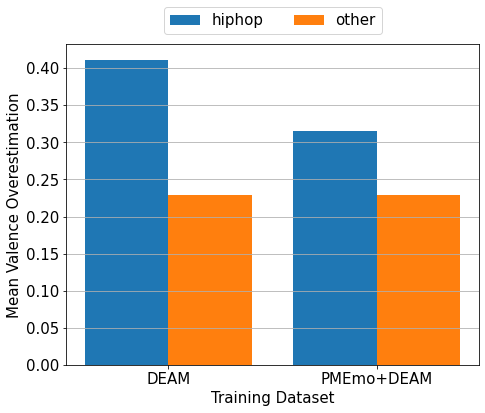

In [34]:
matplotlib.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(7,6))
ax.grid(axis='y')
ax.bar(x=[-0.2, 0.8], height=[pmemo_overestimate_hiphop, combined_overestimate_hiphop], width=0.4, label="hiphop")
ax.bar(x=[0.2,1.2], height=[pmemo_overestimate_other, pmemo_overestimate_other], width=0.4, label="other")
ax.set_xticks([0,1])
ax.set_xticklabels(["DEAM", "PMEmo+DEAM"])
ax.set_xlabel("Training Dataset")
ax.set_ylabel("Mean Valence Overestimation")
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.14), ncol=2)
plt.tight_layout()